Covid 19 prediction using chest x-ray

In [21]:
!nvidia-smi

Sat Sep 11 10:45:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |  15327MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# importing the libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample,shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint

In [23]:
train_df = pd.read_csv('../input/covidx-cxr2/train.txt',sep= ' ')
test_df = pd.read_csv('../input/covidx-cxr2/test.txt',sep=' ')
train_df.head()

,5,ARDSSevere.png,negative,cohen
0,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
1,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
2,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
3,28,pneumocystis-pneumonia-2-PA.png,negative,cohen
4,38,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,negative,cohen


In [24]:
train_df.columns = ['id','filename','result','data_source']
test_df.columns = ['id','filename','result','data_source']
train_df.head()

,id,filename,result,data_source
0,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
1,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
2,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
3,28,pneumocystis-pneumonia-2-PA.png,negative,cohen
4,38,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,negative,cohen


In [25]:
train_df = train_df.drop(['id','data_source'],axis=1)
test_df = test_df.drop(['id','data_source'],axis=1)
train_df.head()

,filename,result
0,acute-respiratory-distress-syndrome-ards-1.jpg,negative
1,acute-respiratory-distress-syndrome-ards.jpg,negative
2,ards-secondary-to-tiger-snake-bite.png,negative
3,pneumocystis-pneumonia-2-PA.png,negative
4,F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg,negative


In [26]:
print( "The training data shape is ",train_df.shape)
print("The number of positive and negative classes in training data is")
print(train_df['result'].value_counts())
print( "The testing data shape is ",test_df.shape)
print("The number of positive and negative classes in testing data is")
print(test_df['result'].value_counts())

The training data shape is  (15950, 2)
The number of positive and negative classes in training data is
negative    13792
positive     2158
Name: result, dtype: int64
The testing data shape is  (399, 2)
The number of positive and negative classes in testing data is
negative    200
positive    199
Name: result, dtype: int64


In [27]:
# The given dataset is a imbalanced dataset. The negative class consist of 13,792 images
# and the positive class consist of 2158 images.
# In this case the model will be more biased towards negative class,
# so we need to balance them

negative = train_df[train_df['result'] == "negative"]
positive = train_df[train_df['result'] == 'positive']
sampled_data = resample(negative,n_samples=2158)
sampled_data

,filename,result
3263,367f60d0-7180-4459-aad0-e36bd6ae4844.png,negative
4945,67305076-ddff-44df-9682-9af7203dd20a.png,negative
13892,afb20c9c-a4bf-4a02-99ea-50d134dadb6b.png,negative
7793,b607b534-48a2-445d-8579-29ef85752d16.png,negative
5375,740824df-92ff-4b09-a8be-dfd3eff172a7.png,negative
...,...,...
4916,666c91a0-ebe2-4487-891b-8105e902ede0.png,negative
7840,b76ebfcd-dc59-4532-8f46-cf21edcfefac.png,negative
12062,591ef0ea-6a2f-4079-9bc2-20c988507809.png,negative
12991,8ace1a2f-7c08-4bc3-88dc-50e2ea032056.png,negative


In [28]:
sampled_data.shape

(2158, 2)

In [29]:
train_df = pd.concat([positive,sampled_data],axis=0,ignore_index=True)
train_df.head()

,filename,result
0,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,positive
1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,positive
2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,positive
3,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,positive
4,nejmc2001573_f1a.jpeg,positive


In [30]:
print('The shape of the new training data is ',train_df.shape)
print("The number of positive and negative classes in training data is")
print(train_df['result'].value_counts())

The shape of the new training data is  (4316, 2)
The number of positive and negative classes in training data is
negative    2158
positive    2158
Name: result, dtype: int64


In [31]:
train_df = shuffle(train_df)
train_df.head()

,filename,result
4,nejmc2001573_f1a.jpeg,positive
2807,fa625855-c4e8-4764-abf3-3013eda34b16.png,negative
1569,MIDRC-RICORD-1C-419639-000331-64221-1.png,positive
1321,MIDRC-RICORD-1C-419639-002884-20903-0.png,positive
1488,MIDRC-RICORD-1C-SITE2-000242-07550-0.png,positive


In [32]:
# splitting the data into training and validation

train_data,val_data = train_test_split(train_df,train_size=0.9,random_state=0,stratify = train_df['result'])

In [33]:
print("Number of training data : ",len(train_data))
print('Number of validation data : ',len(val_data))
print("Number of test data : ",len(test_df))

Number of training data :  3884
Number of validation data :  432
Number of test data :  399


In [34]:
print("Number of positive and negative classes in training data")
print(train_data['result'].value_counts())
print("Number of positive and negative classes in validation data")
print(val_data['result'].value_counts())
print("Number of positive and negative classes in testing data")
print(test_df['result'].value_counts())

Number of positive and negative classes in training data
negative    1942
positive    1942
Name: result, dtype: int64
Number of positive and negative classes in validation data
positive    216
negative    216
Name: result, dtype: int64
Number of positive and negative classes in testing data
negative    200
positive    199
Name: result, dtype: int64


Model Building

In [35]:
image_size = [224,224]
train_path = "../input/covidx-cxr2/train"
test_path = "../input/covidx-cxr2/test"

In [36]:
# using transfer learning model
resnet = ResNet50V2(include_top=False,input_shape=image_size+[3])

In [37]:
# deleting the pretrained weights
for layers in resnet.layers:
    layers.trainable = False

In [38]:
# fully connected layer


final_model = tf.keras.Sequential([
    resnet, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [39]:
# model summary

final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,827,713
Trainable params: 262,657
Non-trainable params: 23,565,056
______________________________________

In [40]:
# data augumentation

train_datagen = ImageDataGenerator(
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1./255,
                validation_split=0.2)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [41]:
val_data.head()

,filename,result
799,COVID(498).png,positive
1865,MIDRC-RICORD-1C-419639-002972-97415-0.png,positive
3594,10363aa1-6671-4c3f-b0ad-d2a7b868ec09.png,negative
3878,c9464c74-1f7f-41a2-a6ac-c72e8afcbb00.png,negative
3901,b1831e52-f668-47a9-a900-f42924698045.png,negative


In [42]:
# fitting the data

training_data = train_datagen.flow_from_dataframe(
                    dataframe=train_data,directory=train_path,
                    x_col='filename',y_col='result',class_mode='binary',batch_size=64,
                    target_size=image_size)

validation_data = test_datagen.flow_from_dataframe(
                    dataframe=val_data,directory=train_path,
                    x_col='filename',y_col='result',class_mode='binary',batch_size=64,
                    target_size=image_size)

testing_data = test_datagen.flow_from_dataframe(
                    dataframe=test_df,directory=test_path,
                    x_col='filename',y_col='result',class_mode='binary',batch_size=64,
                    target_size=image_size)


Found 3884 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.


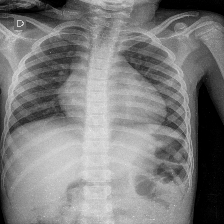

In [3]:
load_img("../input/covidx-cxr2/train/MIDRC-RICORD-1C-SITE2-000205-14473-0.png"
         ,target_size=(224,224))

In [43]:
# tensorflow callbacks

callbacks = [
    EarlyStopping( monitor='val_loss',patience=3, verbose=0,),
    ModelCheckpoint(filepath='covid_detection_model.h5', monitor='val_loss', 
                    verbose=0, save_best_only=True,)
    
]


In [44]:
# compiling the model

final_model.compile(optimizer=Adam(),loss=BinaryCrossentropy(),metrics=['accuracy'])

In [45]:
# training the model

model_history = final_model.fit(training_data,validation_data=validation_data,epochs=20,callbacks=[callbacks],shuffle=True)

Epoch 1/20
61/61 [==============================] - 292s 5s/step - loss: 0.5224 - accuracy: 0.7571 - val_loss: 0.3250 - val_accuracy: 0.8611
Epoch 2/20
61/61 [==============================] - 137s 2s/step - loss: 0.2956 - accuracy: 0.8785 - val_loss: 0.3436 - val_accuracy: 0.8704
Epoch 3/20
61/61 [==============================] - 136s 2s/step - loss: 0.2757 - accuracy: 0.8895 - val_loss: 0.3929 - val_accuracy: 0.8449
Epoch 4/20
61/61 [==============================] - 136s 2s/step - loss: 0.2599 - accuracy: 0.9048 - val_loss: 0.1931 - val_accuracy: 0.9329
Epoch 5/20
61/61 [==============================] - 136s 2s/step - loss: 0.2287 - accuracy: 0.9107 - val_loss: 0.2547 - val_accuracy: 0.9028
Epoch 6/20
61/61 [==============================] - 136s 2s/step - loss: 0.2276 - accuracy: 0.9111 - val_loss: 0.3227 - val_accuracy: 0.8727
Epoch 7/20
61/61 [==============================] - 136s 2s/step - loss: 0.2137 - accuracy: 0.9164 - val_loss: 0.2343 - val_accuracy: 0.9144


In [46]:
final_model.evaluate(testing_data)

7/7 [==============================] - 35s 5s/step - loss: 0.3272 - accuracy: 0.8571


[0.32715046405792236, 0.8571428656578064]

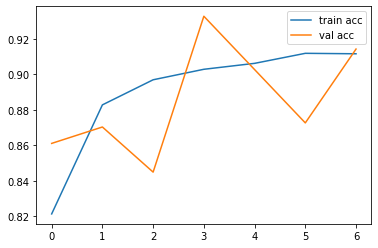

In [47]:
# plotting the accuracy

plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

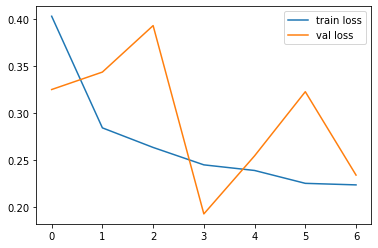

In [48]:
# plotting the loss

plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [49]:
# predicting covid positive or negative in test data

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np   
preds = final_model.predict(testing_data)
predictions = [0 if i<=0.5 else 1 for i in preds]
print(predictions)
print("Number of negative cases in test data: ",predictions.count(0))
print("Number of positive cases in test data: ",predictions.count(1))

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 

In [50]:
# predicting covid positive or negative by uploading image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
model_path = 'covid_detection_model.h5'
image_path = '../input/covidx-cxr2/train/MIDRC-RICORD-1C-SITE2-000205-14473-0.png'
img = image.load_img(image_path,target_size = [224,224])
x = image.img_to_array(img)
x=x/255
x = np.expand_dims(x, axis=0)
preds = final_model.predict(x)
if preds>0.5:
    print('positive')
else:
    print('negative')


negative
